<a href="https://colab.research.google.com/github/aSafarpoor/Dataset-Test/blob/main/Copy_of_Before_the_Learning_Begins!!!_Who_is_My_DATASET%3F_Twibot20.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install networkit

In [ ]:
import numpy as np
import networkx as nx
from tqdm import tqdm
from matplotlib import pyplot as plt
import random
import torch
from collections import deque, defaultdict
import community  # This is from the 'python-louvain' package
from scipy.stats import entropy
import math
import networkit as nk
from networkx.algorithms.approximation import maxcut

In [ ]:
def set_random_seed(seed):
    random.seed(seed)
    np.random.seed(seed)

    try:
        torch.manual_seed(seed)
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False
        print("torch: imported")
    except:
        print("torch: not imported")
    print(f"Random set by seed = {seed}")

set_random_seed(seed = 1)

torch: imported
Random set by seed = 1


# Read Data and Create Graphs (all are directed)

In [ ]:
labels_tensor = torch.load('label.pt')
labels_list = labels_tensor.tolist()
edge_index = torch.load('directed_edge_index.pt')
edge_list = edge_index.t().tolist()
if edge_index.min().item() == 1:
    edge_index = edge_index - 1
    edge_list = edge_index.t().tolist()
    print("edge started by 1 ==> changed to 0")

In [ ]:
def create_subgraphs(edge_list, labels_list):
    G = nx.DiGraph()

    max_node = max(max(u, v) for u, v in edge_list)
    G.add_nodes_from(range(max_node + 1))

    G.add_edges_from(edge_list)

    labeled_nodes = set(range(len(labels_list)))
    benign_nodes = {i for i, label in enumerate(labels_list) if label == 0}
    sybil_nodes = {i for i, label in enumerate(labels_list) if label == 1}

    Gl = G.subgraph(labeled_nodes).copy()
    Gb = G.subgraph(benign_nodes).copy()
    Gs = G.subgraph(sybil_nodes).copy()

    UG = G.to_undirected()
    UGl = Gl.to_undirected()
    UGb = Gb.to_undirected()
    UGs = Gs.to_undirected()

    return G, Gl, Gb, Gs, UG, UGl, UGb, UGs, labeled_nodes, benign_nodes, sybil_nodes
G, Gl, Gb, Gs, UG, UGl, UGb, UGs, labeled_nodes, benign_nodes, sybil_nodes = create_subgraphs(edge_list, labels_list)

# simple parameters

## Single Simple Value

In [ ]:
def analyze_graph(G):
    num_nodes = G.number_of_nodes()
    print("Number of nodes:", num_nodes)
    print("Number of edges:", G.number_of_edges())

    if G.is_directed():
        in_degrees = dict(G.in_degree())
        out_degrees = dict(G.out_degree())

        avg_in_deg = sum(in_degrees.values()) / num_nodes
        avg_out_deg = sum(out_degrees.values()) / num_nodes
        degrees = [in_degrees[n] + out_degrees[n] for n in G.nodes()]

        only_in = sum(1 for n in G.nodes() if in_degrees[n] > 0 and out_degrees[n] == 0)
        only_out = sum(1 for n in G.nodes() if in_degrees[n] == 0 and out_degrees[n] > 0)
        both = sum(1 for n in G.nodes() if in_degrees[n] > 0 and out_degrees[n] > 0)
        isolated = sum(1 for n in G.nodes() if in_degrees[n] == 0 and out_degrees[n] == 0)

        print("Average in-degree:", round(avg_in_deg, 3))
        print("Average out-degree:", round(avg_out_deg, 3))
        print("Only in-edge nodes ratio:", round(only_in / num_nodes, 3))
        print("Only out-edge nodes ratio:", round(only_out / num_nodes, 3))
        print("Nodes with both in and out edges ratio:", round(both / num_nodes, 3))
        print("Isolated nodes ratio:", round(isolated / num_nodes, 3))
    else:
        degrees = dict(G.degree()).values()
        avg_in_deg = avg_out_deg = None
        isolated = sum(1 for n in G.nodes() if G.degree(n) == 0)
        print("Average degree:", round(sum(degrees) / num_nodes, 3))
        print("Isolated nodes ratio:", round(isolated / num_nodes, 3))

    print("Maximum degree:", max(degrees))
    leaf_nodes = [n for n in G.nodes() if G.degree(n) == 1]
    print("Number of leaf nodes:", len(leaf_nodes))

In [ ]:
analyze_graph(G)

Number of nodes: 229580
Number of edges: 227477
Average in-degree: 0.991
Average out-degree: 0.991
Only in-edge nodes ratio: 0.396
Only out-edge nodes ratio: 0.438
Nodes with both in and out edges ratio: 0.062
Isolated nodes ratio: 0.104
Maximum degree: 139
Number of leaf nodes: 183180


In [ ]:
analyze_graph(Gl)

Number of nodes: 11826
Number of edges: 16573
Average in-degree: 1.401
Average out-degree: 1.401
Only in-edge nodes ratio: 0.321
Only out-edge nodes ratio: 0.37
Nodes with both in and out edges ratio: 0.231
Isolated nodes ratio: 0.078
Maximum degree: 104
Number of leaf nodes: 5207


In [ ]:
analyze_graph(Gb)

Number of nodes: 5237
Number of edges: 4655
Average in-degree: 0.889
Average out-degree: 0.889
Only in-edge nodes ratio: 0.292
Only out-edge nodes ratio: 0.246
Nodes with both in and out edges ratio: 0.158
Isolated nodes ratio: 0.303
Maximum degree: 45
Number of leaf nodes: 1711


In [ ]:
analyze_graph(Gs)

Number of nodes: 6589
Number of edges: 4182
Average in-degree: 0.635
Average out-degree: 0.635
Only in-edge nodes ratio: 0.231
Only out-edge nodes ratio: 0.287
Nodes with both in and out edges ratio: 0.103
Isolated nodes ratio: 0.379
Maximum degree: 22
Number of leaf nodes: 3085


In [ ]:
# Standard Deviation of Degrees

# Interpretation (comment only):
#  - Low std → uniform structure (e.g., lattice, sybil net)
#  - High std → heterogeneous, hub-based structure (e.g., scale-free, OSN)

def compute_degree_std(G):
    degrees = [deg for _, deg in G.degree()]
    std = np.std(degrees)
    print(f"Standard Deviation of Degree: {std:.4f} and avg is {round(np.mean(degrees),2)}")

# Standard Deviation of In-Degree and Out-Degree for Directed Graphs

# Interpretation (comment only):
#  - In-degree std → variation in how much attention nodes receive
#  - Out-degree std → variation in how active nodes are
#  - Low std → uniform behavior (e.g., botnet)
#  - High std → diverse behavior (e.g., real OSNs)

def compute_directed_degree_std(G):
    if not G.is_directed():
        return None

    in_degrees = [deg for _, deg in G.in_degree()]
    out_degrees = [deg for _, deg in G.out_degree()]

    in_std = np.std(in_degrees)
    out_std = np.std(out_degrees)

    print(f"In-Degree Std:  {in_std:.4f} and avg is {round(np.mean(in_std),2)}")
    print(f"Out-Degree Std: {out_std:.4f} and avg is {round(np.mean(out_std),2)}")


In [ ]:
compute_degree_std(UG)
compute_degree_std(UGl)
compute_degree_std(UGs)
compute_degree_std(UGb)

Standard Deviation of Degree: 4.3963 and avg is 1.97
Standard Deviation of Degree: 4.3585 and avg is 2.76
Standard Deviation of Degree: 2.5292 and avg is 1.24
Standard Deviation of Degree: 2.5749 and avg is 1.76


In [ ]:
compute_directed_degree_std(G)
compute_directed_degree_std(Gl)
compute_directed_degree_std(Gs)
compute_directed_degree_std(Gb)

In-Degree Std:  2.4081 and avg is 2.41
Out-Degree Std: 2.2552 and avg is 2.26
In-Degree Std:  3.1386 and avg is 3.14
Out-Degree Std: 2.2197 and avg is 2.22
In-Degree Std:  1.4975 and avg is 1.5
Out-Degree Std: 1.3077 and avg is 1.31
In-Degree Std:  1.8146 and avg is 1.81
Out-Degree Std: 1.6598 and avg is 1.66


In [ ]:
def print_sparsity_ratio(G):
    n = G.number_of_nodes()
    m = G.number_of_edges()
    print(n,m)
    if nx.is_directed(G):
        max_edges = n * (n - 1)
        print("Graph is directed.")
    else:
        max_edges = n * (n - 1) // 2
        print("Graph is undirected.")

    if max_edges == 0:
        sparsity_ratio = 0.0
    else:
        sparsity_ratio = m / max_edges

    print(f"Sparsity ratio: {sparsity_ratio:.6f}")



In [ ]:
print_sparsity_ratio(G)

229580 227477
Graph is directed.
Sparsity ratio: 0.000004


In [ ]:
print_sparsity_ratio(UG)

229580 226111
Graph is undirected.
Sparsity ratio: 0.000009


In [ ]:
print_sparsity_ratio(UGl)

11826 16349
Graph is undirected.
Sparsity ratio: 0.000234


In [ ]:
def largest_connected_component(UG):
    components = list(nx.connected_components(UG))
    largest = max(components, key=len)
    UG_largest = UG.subgraph(largest).copy()
    print(f"Number of nodes in largest component: {UG_largest.number_of_nodes()}")
    print(f"Number of edges in largest component: {UG_largest.number_of_edges()}")
    print(f"#edge/#node = {round(UG_largest.number_of_edges()/UG_largest.number_of_nodes(),2)}")
    return UG_largest
UC_largest_component = largest_connected_component(UG)

Number of nodes in largest component: 203279
Number of edges in largest component: 223782
#edge/#node = 1.1


In [ ]:
def largest_weakly_connected_component(G):
    components = list(nx.weakly_connected_components(G))
    largest = max(components, key=len)
    G_largest = G.subgraph(largest).copy()
    print(f"Number of nodes in largest weakly connected component: {G_largest.number_of_nodes()}")
    print(f"Number of edges in largest weakly connected component: {G_largest.number_of_edges()}")
    print(f"#edge/#node = {round(G_largest.number_of_edges() / G_largest.number_of_nodes(), 2)}")
    return G_largest

G_largest_weakly_component = largest_weakly_connected_component(G)

Number of nodes in largest weakly connected component: 203279
Number of edges in largest weakly connected component: 225139
#edge/#node = 1.11


In [ ]:
def analyze_scc_components(G):
    if not isinstance(G, nx.DiGraph):
        raise ValueError("G must be a directed graph")

    def report_sccs(graph, label):
        sccs = list(nx.strongly_connected_components(graph))
        sizes = [len(c) for c in sccs]
        small = [s for s in sizes if s < 10]
        large = sorted([s for s in sizes if s >= 10], reverse=True)

        print(f"\nSCC Analysis for {label}:")
        print(f"Total number of SCCs: {len(sccs)}")
        print(f"Number of SCCs with size < 10: {len(small)}")
        print(f"Sizes of SCCs with size ≥ 10 (sorted): {large}")

    report_sccs(G, "original G")
    report_sccs(G.reverse(copy=True), "reversed G")


analyze_scc_components(G)


SCC Analysis for original G:
Total number of SCCs: 226065
Number of SCCs with size < 10: 226050
Sizes of SCCs with size ≥ 10 (sorted): [2171, 26, 25, 18, 16, 15, 14, 14, 14, 14, 11, 11, 11, 10, 10]

SCC Analysis for reversed G:
Total number of SCCs: 226065
Number of SCCs with size < 10: 226050
Sizes of SCCs with size ≥ 10 (sorted): [2171, 26, 25, 18, 16, 15, 14, 14, 14, 14, 11, 11, 11, 10, 10]


In [ ]:
def analyze_directional_label_distribution(G, labels_list):
    import numpy as np
    import matplotlib.pyplot as plt

    if not G.is_directed():
        raise ValueError("Graph must be directed.")

    k = len(labels_list)

    def label_of(node):
        if node >= k:
            return 2  # unknown
        return labels_list[node]

    label_names = ['Benign', 'Sybil', 'Unknown']

    # ----------- Table 1: 3x3 edge direction matrix -----------
    edge_table = np.zeros((3, 3), dtype=int)
    for u, v in G.edges():
        src = label_of(u)
        tgt = label_of(v)
        edge_table[src][tgt] += 1

    # ----------- Table 2: in/out-degree of benign and sybil -----------
    degree_table = np.zeros((2, 2), dtype=float)  # Rows: in/out, Cols: benign/sybil
    counts = np.zeros(2, dtype=int)  # benign, sybil

    for node in G.nodes():
        if node >= k:
            continue
        label = labels_list[node]
        if label == 0:
            degree_table[0][0] += G.in_degree(node)
            degree_table[1][0] += G.out_degree(node)
            counts[0] += 1
        elif label == 1:
            degree_table[0][1] += G.in_degree(node)
            degree_table[1][1] += G.out_degree(node)
            counts[1] += 1

    degree_table[0][0] /= counts[0] if counts[0] > 0 else 1
    degree_table[1][0] /= counts[0] if counts[0] > 0 else 1
    degree_table[0][1] /= counts[1] if counts[1] > 0 else 1
    degree_table[1][1] /= counts[1] if counts[1] > 0 else 1

    # ----------- Plot both heatmaps side by side -----------
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))  # Smaller and side-by-side

    # Heatmap 1: Edge direction matrix
    im1 = ax1.imshow(edge_table, cmap="YlOrRd")
    ax1.set_xticks(range(3))
    ax1.set_yticks(range(3))
    ax1.set_xticklabels(label_names, fontsize=13)
    ax1.set_yticklabels(label_names, fontsize=13)
    ax1.set_title("Edge Ratios (Src ➝ Tgt)", fontsize=14)
    for i in range(3):
        for j in range(3):
            ax1.text(j, i, edge_table[i, j], ha='center', va='center', color='black', fontsize=11)
    ax1.set_xlabel("Target", fontsize=13)
    ax1.set_ylabel("Source", fontsize=13)
    fig.colorbar(im1, ax=ax1, shrink=0.8)

    # Heatmap 2: Degree stats
    im2 = ax2.imshow(degree_table, cmap="PuBuGn")
    ax2.set_xticks([0, 1])
    ax2.set_yticks([0, 1])
    ax2.set_xticklabels(['Benign', 'Sybil'], fontsize=13)
    ax2.set_yticklabels(['In-degree', 'Out-degree'], fontsize=13)
    ax2.set_title("Avg In/Out Degree", fontsize=14)
    for i in range(2):
        for j in range(2):
            ax2.text(j, i, f"{degree_table[i, j]:.2f}", ha='center', va='center', color='black', fontsize=11)
    fig.colorbar(im2, ax=ax2, shrink=0.8)

    plt.tight_layout()
    plt.show()


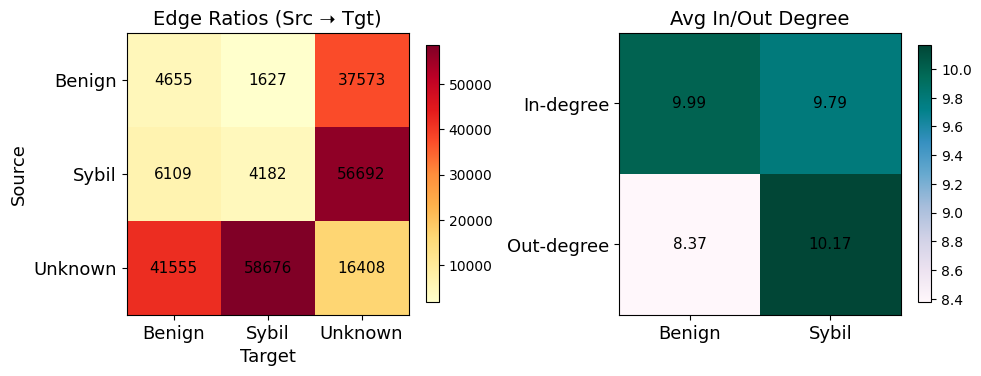

In [ ]:
analyze_directional_label_distribution(G, labels_list)

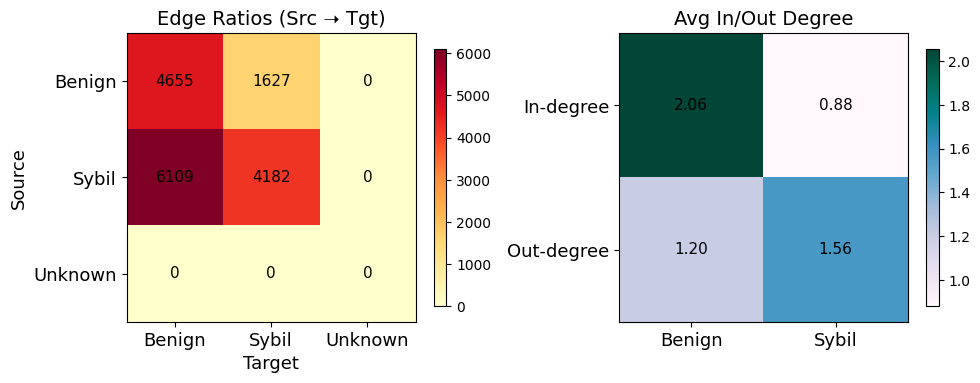

In [ ]:
analyze_directional_label_distribution(Gl, labels_list)

In [ ]:
def count_isolated_by_label(G, labels_list):
    isolated_nodes = list(nx.isolates(G))

    benign_isolated = sum(1 for node in isolated_nodes if node < len(labels_list) and labels_list[node] == 0)
    sybil_isolated = sum(1 for node in isolated_nodes if node < len(labels_list) and labels_list[node] == 1)

    print(f"Isolated benign nodes in undirected graph of whole nodes: {benign_isolated}, whole benign nodes are {len(labels_list)-sum(labels_list)}")
    print(f"Isolated  sybil nodes in undirected graph of whole nodes: {sybil_isolated},  whole benign nodes are {sum(labels_list)}")

count_isolated_by_label(UG, labels_list)

Isolated benign nodes in undirected graph of whole nodes: 10, whole benign nodes are 5237
Isolated  sybil nodes in undirected graph of whole nodes: 2,  whole benign nodes are 6589


## Degree Distribution

In [ ]:
def clip_top_5_percent(values):
    values = np.array(values)
    threshold = np.percentile(values, 97)  # 95th percentile value
    clip_val = np.min(values[values >= threshold])
    clipped = np.where(values > clip_val, clip_val, values)
    return clipped, clip_val

def plot_degree_distributions(G, name="Graph"):
    fig, axes = plt.subplots(1, 3, figsize=(18, 5))

    if G.is_directed():
        in_degrees = [d for _, d in G.in_degree()]
        out_degrees = [d for _, d in G.out_degree()]
        total_degrees = [in_d + out_d for in_d, out_d in zip(in_degrees, out_degrees)]
    else:
        in_degrees = out_degrees = total_degrees = [d for _, d in G.degree()]

    # Clip top 5% of each list
    total_degrees_clipped, clip_total = clip_top_5_percent(total_degrees)
    in_degrees_clipped, clip_in = clip_top_5_percent(in_degrees)
    out_degrees_clipped, clip_out = clip_top_5_percent(out_degrees)

    # Plot Degree
    axes[0].hist(total_degrees_clipped, bins=30, color='skyblue', edgecolor='black')
    axes[0].set_title(f"{name} - Degree")
    axes[0].set_xlabel("Degree")
    axes[0].set_ylabel("Frequency")

    # Plot In-Degree
    axes[1].hist(in_degrees_clipped, bins=30, color='lightgreen', edgecolor='black')
    axes[1].set_title(f"{name} - In-Degree")
    axes[1].set_xlabel("In-Degree")
    axes[1].set_ylabel("Frequency")

    # Plot Out-Degree
    axes[2].hist(out_degrees_clipped, bins=30, color='salmon', edgecolor='black')
    axes[2].set_title(f"{name} - Out-Degree")
    axes[2].set_xlabel("Out-Degree")
    axes[2].set_ylabel("Frequency")

    # Add clipping info
    fig.suptitle(f"Degree Distributions for {name}", fontsize=16)
    fig.text(0.5, 0.01, f"Clipped top 3% values to: Degree={clip_total}, In-Degree={clip_in}, Out-Degree={clip_out}",
             ha='center', fontsize=10, style='italic')

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()


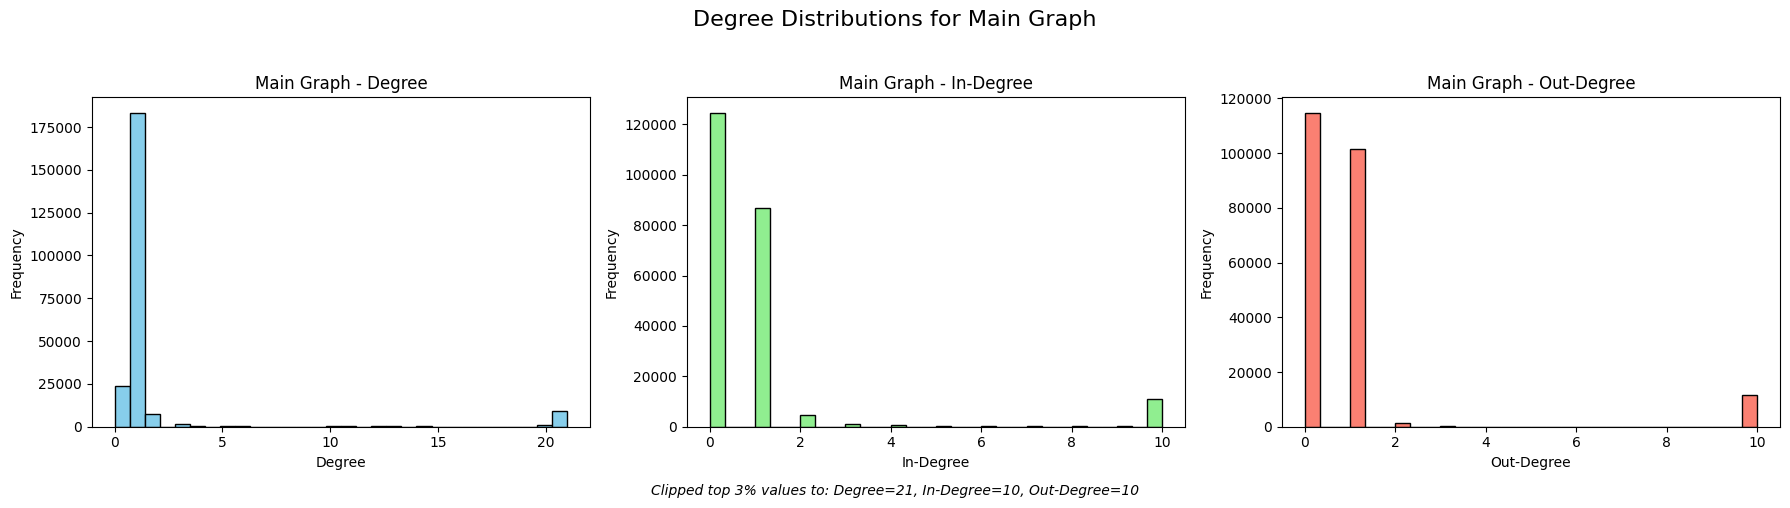

In [ ]:
plot_degree_distributions(G, name="Main Graph")

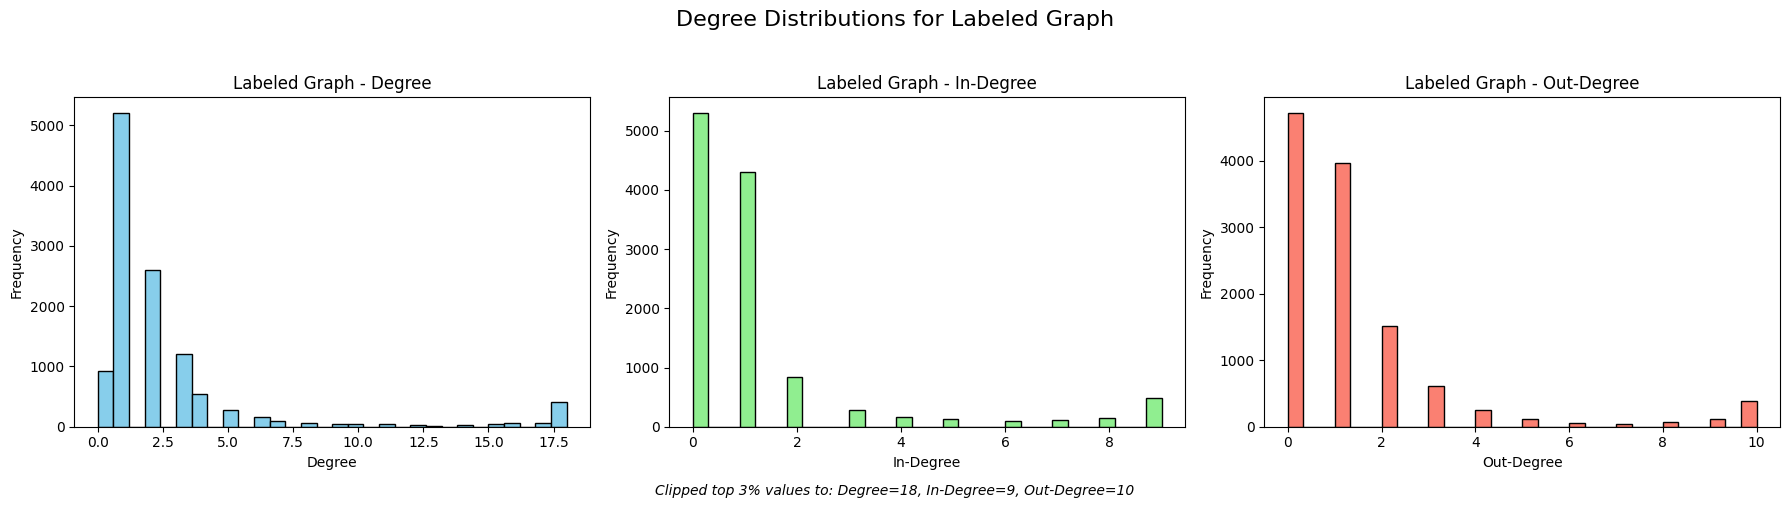

In [ ]:
plot_degree_distributions(Gl, name="Labeled Graph")

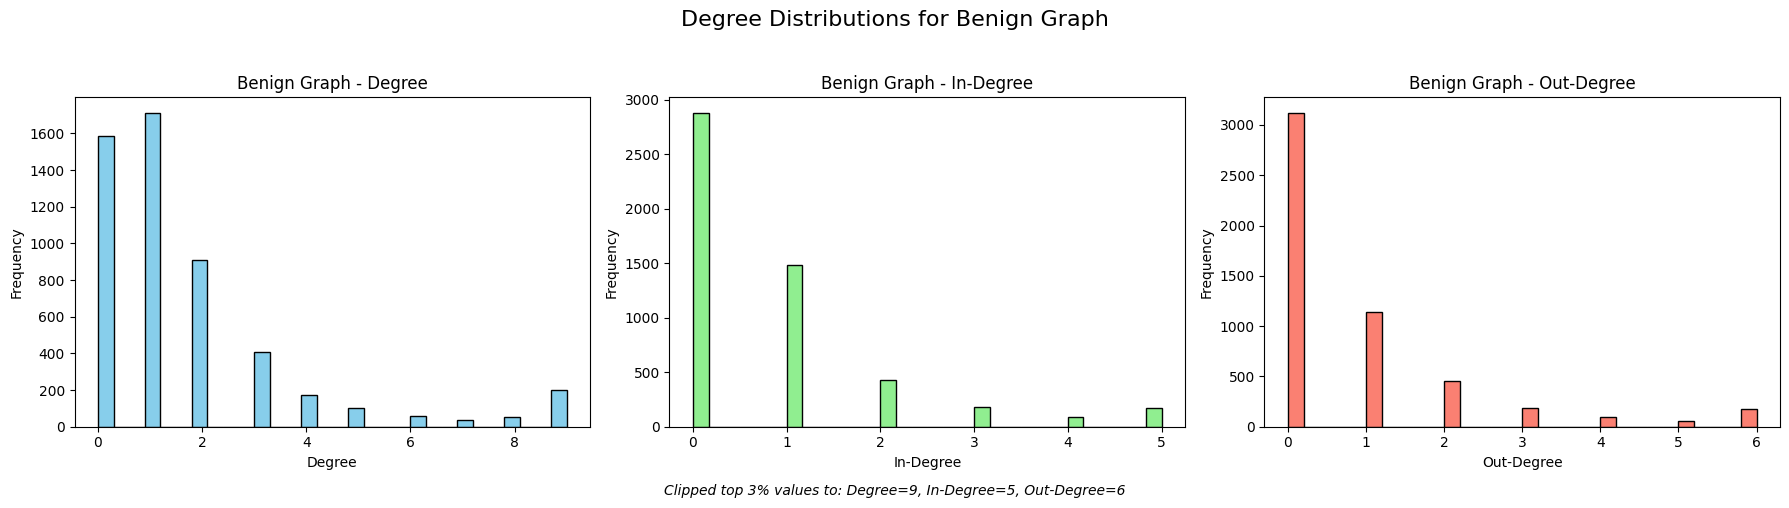

In [ ]:
plot_degree_distributions(Gb, name="Benign Graph")

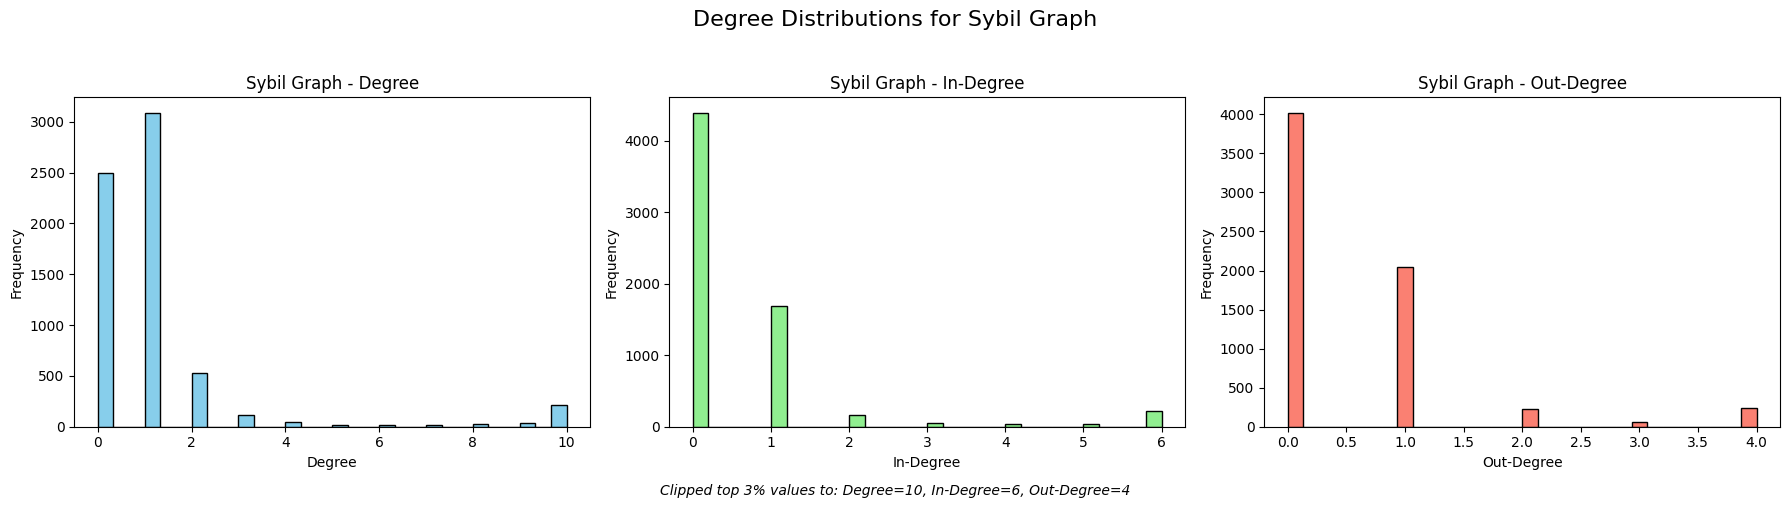

In [ ]:
plot_degree_distributions(Gs, name="Sybil Graph")

# Heteroginity Talk (Undirected Labeled Graph)

In [ ]:
def plot_node_heterogeneity(G, label_list):
    benign_het_ratios = []
    sybil_het_ratios = []
    all_het_ratios = []

    labeled_nodes = {i for i, lbl in enumerate(label_list) if lbl in [0, 1]}
    total_labeled = len(labeled_nodes)
    isolated_labeled = 0

    for node in labeled_nodes:
        label = label_list[node]

        if G.is_directed():
            neighbors = set(G.predecessors(node)) | set(G.successors(node))
        else:
            neighbors = G.neighbors(node)

        labeled_neighbors = [n for n in neighbors if n < len(label_list) and label_list[n] in [0, 1]]

        if not labeled_neighbors:
            isolated_labeled += 1
            continue

        het_count = sum(1 for n in labeled_neighbors if label_list[n] != label)
        het_ratio = het_count / len(labeled_neighbors)

        all_het_ratios.append(het_ratio)
        if label == 0:
            benign_het_ratios.append(het_ratio)
        elif label == 1:
            sybil_het_ratios.append(het_ratio)

    isolated_ratio = isolated_labeled / total_labeled if total_labeled > 0 else 0

    # Plotting
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))

    # Histogram 1: All labeled nodes
    axes[0].hist(all_het_ratios, bins=30, color='steelblue', edgecolor='black', alpha=0.8)
    axes[0].set_title("Heterogeneity Ratio (All Labeled Nodes)")
    axes[0].set_xlabel("Heterogeneity Ratio")
    axes[0].set_ylabel("Density")

    # Histogram 2: Benign vs Sybil nodes
    axes[1].hist(benign_het_ratios, bins=30, alpha=0.5, label='Benign', color='green', density=True)
    axes[1].hist(sybil_het_ratios, bins=30, alpha=0.5, label='Sybil', color='red', density=True)
    axes[1].set_title("Heterogeneity Ratio by Class")
    axes[1].set_xlabel("Heterogeneity Ratio")
    axes[1].set_ylabel("Density")
    axes[1].legend()

    # Caption below both plots
    caption = f"Note: {round(isolated_ratio * 100, 2)}% of labeled nodes were isolated and excluded from analysis."
    fig.text(0.5, -0.02, caption, ha='center', fontsize=10, style='italic')

    plt.tight_layout(rect=[0, 0.04, 1, 1])
    plt.show()

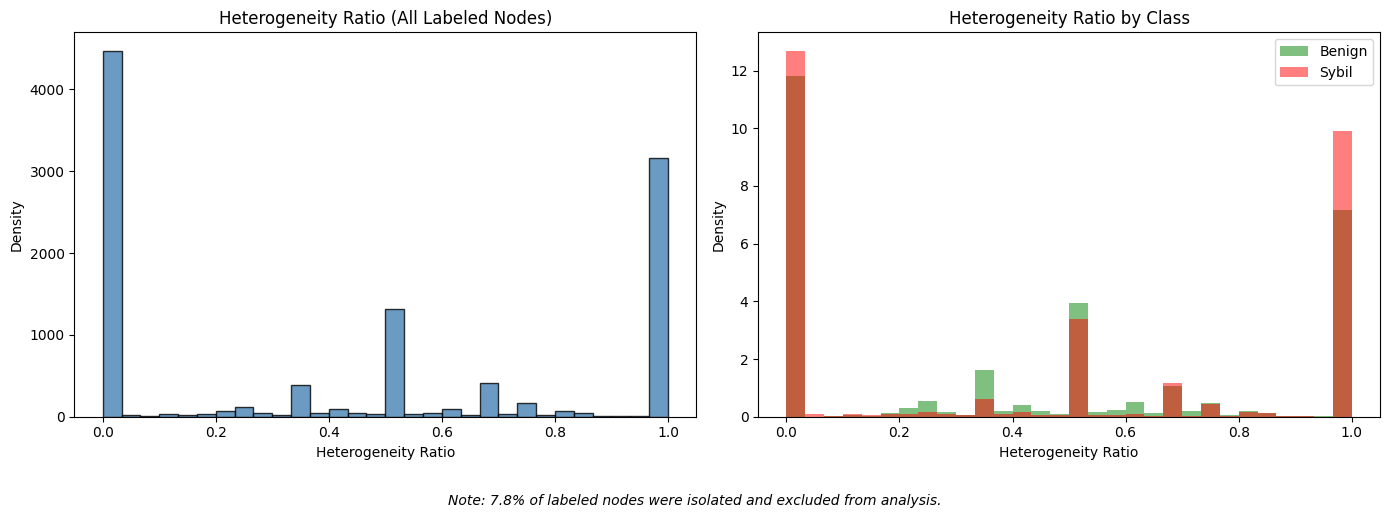

In [ ]:
plot_node_heterogeneity(UGl, labels_list)

# BFS (undirected scenario)

In [ ]:
def bfs_levels_from_virtual_node(G, first_level_list):
    G = G.copy()
    virtual_node = -1

    G.add_node(virtual_node)
    for node in first_level_list:
        G.add_edge(virtual_node, node)

    visited = set([virtual_node])
    level_map = {virtual_node: 0}
    queue = deque([virtual_node])

    level_nodes = defaultdict(list)

    while queue:
        current = queue.popleft()
        current_level = level_map[current]

        for neighbor in G.neighbors(current):
            if neighbor not in visited:
                visited.add(neighbor)
                level_map[neighbor] = current_level + 1
                level_nodes[current_level + 1].append(neighbor)
                queue.append(neighbor)


    original_nodes = set(G.nodes()) - {virtual_node}
    print("BFS Level Summary (excluding virtual node):")
    for level in sorted(level_nodes.keys()):
        nodes_at_level = level_nodes[level]
        avg_deg = sum(G.degree(n) for n in nodes_at_level) / len(nodes_at_level)
        print(f"Level {level}: {len(nodes_at_level)} nodes, average degree: {round(avg_deg, 2)}")

    all_reachable = set(level_map.keys()) - {virtual_node}
    non_reachable = original_nodes - all_reachable
    isolated_nodes = list(nx.isolates(G))
    num_non_reachable = len(non_reachable)
    num_isolated_non_reachable = len(set(isolated_nodes) & non_reachable)

    if len(original_nodes) > 0:
        print(f"Non-reachable nodes: {num_non_reachable} ({round(num_non_reachable / len(original_nodes) * 100, 2)}%)")
        if num_non_reachable > 0:
            isolated_ratio = num_isolated_non_reachable / num_non_reachable
            print(f"Among the unreachabel, isolated nodes: {num_isolated_non_reachable} ({round(isolated_ratio * 100, 2)}%)")

    else:
        print("No nodes in the original graph.")


In [ ]:
bfs_levels_from_virtual_node(UG, first_level_list = labeled_nodes) # whole labeled nodes

BFS Level Summary (excluding virtual node):
Level 1: 11826 nodes, average degree: 20.13
Level 2: 179978 nodes, average degree: 1.17
Level 3: 12214 nodes, average degree: 1.15
Level 4: 1621 nodes, average degree: 1.04
Level 5: 19 nodes, average degree: 1.0
Non-reachable nodes: 23922 (10.42%)
Among the unreachabel, isolated nodes: 23838 (99.65%)


In [ ]:
bfs_levels_from_virtual_node(UG, first_level_list = benign_nodes) # Benign nodes

BFS Level Summary (excluding virtual node):
Level 1: 5237 nodes, average degree: 19.27
Level 2: 78326 nodes, average degree: 2.1
Level 3: 62136 nodes, average degree: 2.03
Level 4: 55571 nodes, average degree: 1.08
Level 5: 2918 nodes, average degree: 1.1
Level 6: 263 nodes, average degree: 1.07
Level 7: 18 nodes, average degree: 1.0
Non-reachable nodes: 25111 (10.94%)
Among the unreachabel, isolated nodes: 23840 (94.94%)


In [ ]:
bfs_levels_from_virtual_node(UG, first_level_list = sybil_nodes) # Sybil nodes

BFS Level Summary (excluding virtual node):
Level 1: 6589 nodes, average degree: 20.81
Level 2: 111842 nodes, average degree: 1.63
Level 3: 43441 nodes, average degree: 2.12
Level 4: 40355 nodes, average degree: 1.06
Level 5: 1747 nodes, average degree: 1.33
Level 6: 516 nodes, average degree: 1.04
Level 7: 19 nodes, average degree: 1.0
Non-reachable nodes: 25071 (10.92%)
Among the unreachabel, isolated nodes: 23848 (95.12%)


# Talk abput connected components

In [ ]:
def format_avg(value):
    return f"{int(value)}" if value.is_integer() else f"{value:.2f}"

def analyze_components_with_labels(G, labels_list, plotter):
    if G.is_directed():
        G = G.to_undirected()

    k = len(labels_list)
    components = list(nx.connected_components(G))
    size_dict = defaultdict(list)
    plot_list = []

    for comp in components:
        subgraph = G.subgraph(comp)
        size = subgraph.number_of_nodes()
        size_dict[size].append(subgraph)
        plot_list.append(size)

    sorted_sizes = sorted(size_dict.keys(), reverse=True)

    # Track biggest component stats separately
    biggest_component = size_dict[sorted_sizes[0]][0]
    benign_big = sybil_big = 0
    for node in biggest_component.nodes:
        if node < k:
            if labels_list[node] == 0:
                benign_big += 1
            elif labels_list[node] == 1:
                sybil_big += 1

    # Track other components' stats
    benign_other = sybil_other = 0
    for size in sorted_sizes[1:]:
        for sg in size_dict[size]:
            for node in sg.nodes:
                if node < k:
                    if labels_list[node] == 0:
                        benign_other += 1
                    elif labels_list[node] == 1:
                        sybil_other += 1

    print(f"# of sybils and benigns in biggest component is {sybil_big}, {benign_big} respectively.")
    print(f"# of sybils and benigns in other   components is {sybil_other}, {benign_other} respectively.")

    for size in sorted_sizes:
        subgraphs = size_dict[size]
        count = len(subgraphs)

        total_edges = total_benigns = total_sybils = 0
        for sg in subgraphs:
            total_edges += sg.number_of_edges()
            for node in sg.nodes:
                if node < k:
                    if labels_list[node] == 0:
                        total_benigns += 1
                    elif labels_list[node] == 1:
                        total_sybils += 1

        avg_edges = total_edges / count
        avg_benigns = total_benigns / count
        avg_sybils = total_sybils / count

        print(
            f"{count} component(s) with size {size}, "
            f"avg edges: {format_avg(avg_edges)}, "
            f"avg benigns: {format_avg(avg_benigns)}, "
            f"avg sybils: {format_avg(avg_sybils)}"
        )

    if plotter:
        plot_list.sort()
        plt.figure(figsize=(8, 5))
        plt.plot(range(1, len(plot_list) + 1), plot_list)
        plt.xlabel("Components")
        plt.ylabel("Size (Logarithmic)")
        plt.yscale("log")
        plt.title("Size of components in sorted format")
        plt.grid(True, which="both", linestyle="--", linewidth=0.5)
        plt.tight_layout()
        plt.show()


# of sybils and benigns in biggest component is 6527, 5169 respectively.
# of sybils and benigns in other   components is 62, 68 respectively.
1 component(s) with size 203279, avg edges: 223782, avg benigns: 5169, avg sybils: 6527
1 component(s) with size 41, avg edges: 40, avg benigns: 1, avg sybils: 1
99 component(s) with size 21, avg edges: 20, avg benigns: 0.47, avg sybils: 0.51
7 component(s) with size 20, avg edges: 19, avg benigns: 0.43, avg sybils: 0.57
1 component(s) with size 19, avg edges: 18, avg benigns: 1, avg sybils: 0
1 component(s) with size 16, avg edges: 15, avg benigns: 1, avg sybils: 0
1 component(s) with size 15, avg edges: 14, avg benigns: 0, avg sybils: 0
1 component(s) with size 14, avg edges: 13, avg benigns: 0, avg sybils: 0
2 component(s) with size 13, avg edges: 12, avg benigns: 0.50, avg sybils: 0
2 component(s) with size 12, avg edges: 11, avg benigns: 0, avg sybils: 1
7 component(s) with size 11, avg edges: 10, avg benigns: 0.57, avg sybils: 0.43
23850 c

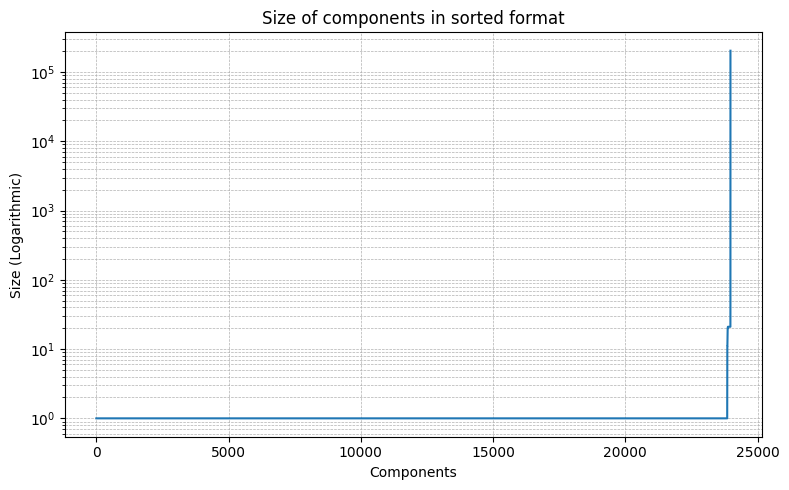

In [ ]:
analyze_components_with_labels(UG, labels_list, plotter = True)

In [ ]:
analyze_components_with_labels(UGb, labels_list, plotter = False)

# of sybils and benigns in biggest component is 0, 3405 respectively.
# of sybils and benigns in other   components is 0, 1832 respectively.
1 component(s) with size 3405, avg edges: 4461, avg benigns: 3405, avg sybils: 0
1 component(s) with size 11, avg edges: 10, avg benigns: 11, avg sybils: 0
1 component(s) with size 10, avg edges: 9, avg benigns: 10, avg sybils: 0
1 component(s) with size 8, avg edges: 7, avg benigns: 8, avg sybils: 0
1 component(s) with size 6, avg edges: 5, avg benigns: 6, avg sybils: 0
1 component(s) with size 5, avg edges: 4, avg benigns: 5, avg sybils: 0
4 component(s) with size 4, avg edges: 3, avg benigns: 4, avg sybils: 0
18 component(s) with size 3, avg edges: 2, avg benigns: 3, avg sybils: 0
67 component(s) with size 2, avg edges: 1, avg benigns: 2, avg sybils: 0
1588 component(s) with size 1, avg edges: 0, avg benigns: 1, avg sybils: 0


In [ ]:
analyze_components_with_labels(UGs, labels_list, plotter = False)

# of sybils and benigns in biggest component is 2008, 0 respectively.
# of sybils and benigns in other   components is 4581, 0 respectively.
1 component(s) with size 2008, avg edges: 2136, avg benigns: 0, avg sybils: 2008
1 component(s) with size 150, avg edges: 158, avg benigns: 0, avg sybils: 150
1 component(s) with size 57, avg edges: 56, avg benigns: 0, avg sybils: 57
1 component(s) with size 47, avg edges: 52, avg benigns: 0, avg sybils: 47
1 component(s) with size 44, avg edges: 56, avg benigns: 0, avg sybils: 44
1 component(s) with size 43, avg edges: 42, avg benigns: 0, avg sybils: 43
1 component(s) with size 35, avg edges: 35, avg benigns: 0, avg sybils: 35
1 component(s) with size 25, avg edges: 24, avg benigns: 0, avg sybils: 25
1 component(s) with size 24, avg edges: 23, avg benigns: 0, avg sybils: 24
1 component(s) with size 23, avg edges: 23, avg benigns: 0, avg sybils: 23
1 component(s) with size 22, avg edges: 21, avg benigns: 0, avg sybils: 22
2 component(s) with size 

In [ ]:
def analyze_tree_components(G, labels_list):
    if G.is_directed():
        G = G.to_undirected()

    k = len(labels_list)
    components = list(nx.connected_components(G))

    for comp in components:
        subgraph = G.subgraph(comp)
        n = subgraph.number_of_nodes()
        m = subgraph.number_of_edges()

        if n != m + 1 or n == 1:
            continue  # Not a tree

        degrees = dict(subgraph.degree())
        deg_values = list(degrees.values())
        is_star = deg_values.count(1) == n - 1 and deg_values.count(n - 1) == 1
        is_path = deg_values.count(1) == 2 and deg_values.count(2) == n - 2

        center_label_info = ""
        if is_star:
            shape = "Star"
            center_node = max(degrees, key=degrees.get)
            if center_node < k:
                if labels_list[center_node] == 0:
                    center_label_info = " Center is benign."
                elif labels_list[center_node] == 1:
                    center_label_info = " Center is sybil."
                else:
                    center_label_info = " Center label unknown."
            else:
                center_label_info = " Center is unlabeled."
        elif is_path:
            shape = "Path"
        else:
            shape = "Other Tree"

        sybils = benigns = 0
        for node in subgraph.nodes:
            if node < k:
                if labels_list[node] == 0:
                    benigns += 1
                elif labels_list[node] == 1:
                    sybils += 1

        print(
            f"Tree component with {n} nodes and {m} edges is a {shape}. "
            f"Sybils: {sybils}, Benigns: {benigns}.{center_label_info if is_star else ''}"
        )


In [ ]:
analyze_tree_components(UG, labels_list)

Tree component with 21 nodes and 20 edges is a Star. Sybils: 1, Benigns: 0. Center is sybil.
Tree component with 21 nodes and 20 edges is a Star. Sybils: 0, Benigns: 1. Center is benign.
Tree component with 21 nodes and 20 edges is a Star. Sybils: 0, Benigns: 1. Center is benign.
Tree component with 21 nodes and 20 edges is a Star. Sybils: 0, Benigns: 1. Center is benign.
Tree component with 21 nodes and 20 edges is a Star. Sybils: 0, Benigns: 1. Center is benign.
Tree component with 21 nodes and 20 edges is a Star. Sybils: 0, Benigns: 1. Center is benign.
Tree component with 21 nodes and 20 edges is a Star. Sybils: 0, Benigns: 1. Center is benign.
Tree component with 21 nodes and 20 edges is a Star. Sybils: 0, Benigns: 1. Center is benign.
Tree component with 20 nodes and 19 edges is a Star. Sybils: 0, Benigns: 1. Center is benign.
Tree component with 21 nodes and 20 edges is a Star. Sybils: 0, Benigns: 1. Center is benign.
Tree component with 20 nodes and 19 edges is a Star. Sybils: 

# clustering

In [ ]:
def analyze_louvain_on_large_components(G, labels_list,print_clusters = False):
    if G.is_directed():
        G = G.to_undirected()

    k = len(labels_list)
    total_nodes = G.number_of_nodes()
    components = list(nx.connected_components(G))
    threshold = total_nodes / 5

    for idx, comp in enumerate(components):
        if len(comp) < threshold:
            continue

        subgraph = G.subgraph(comp).copy()
        nodes = list(subgraph.nodes)
        size = len(nodes)

        benigns = sybils = 0
        for node in nodes:
            if node < k:
                if labels_list[node] == 0:
                    benigns += 1
                elif labels_list[node] == 1:
                    sybils += 1

        print(f"\nConnected component {idx+1} has {size} nodes: Benigns = {benigns}, Sybils = {sybils}")

        partition = community.best_partition(subgraph)
        clusters = defaultdict(list)
        for node, comm_id in partition.items():
            clusters[comm_id].append(node)

        small_clusters_total = 0
        small_clusters_benign = 0
        small_clusters_sybil = 0

        all_clusters = []  # [(comm_id, cluster_size, c_benign, c_sybil)]

        for comm_id, cluster_nodes in clusters.items():
            cluster_size = len(cluster_nodes)
            c_benign = c_sybil = 0
            for node in cluster_nodes:
                if node < k:
                    if labels_list[node] == 0:
                        c_benign += 1
                    elif labels_list[node] == 1:
                        c_sybil += 1

            all_clusters.append((comm_id, cluster_size, c_benign, c_sybil))
            if print_clusters:
                if cluster_size <= 5:
                    small_clusters_total += cluster_size
                    small_clusters_benign += c_benign
                    small_clusters_sybil += c_sybil
                else:
                    print(f"  Cluster {comm_id}: Size = {cluster_size}, Benigns = {c_benign}, Sybils = {c_sybil}")

        print(f"  (Skipped {small_clusters_total} nodes in small clusters ≤ 5; Benigns = {small_clusters_benign}, Sybils = {small_clusters_sybil})")

        # === Analysis: Dominant Clusters ===
        sybil_dominated = [
            (cid, sz, b, s) for cid, sz, b, s in all_clusters
            if s >= 3 * (b + 1e-6) and s >= 30
        ]
        benign_dominated = [
            (cid, sz, b, s) for cid, sz, b, s in all_clusters
            if b >= 3 * (s + 1e-6) and b >= 30
        ]

        print(f"  Number of sybil-dominated clusters  (sybils ≥3× benigns and sybils ≥30 ): {len(sybil_dominated)}")
        print(f"  Number of benign-dominated clusters (benigns ≥3× sybils and benigns ≥30): {len(benign_dominated)}")

        # === Analysis: Skewed Distribution ===
        total_sybils = sum(s for _, _, _, s in all_clusters)
        total_benigns = sum(b for _, _, b, _ in all_clusters)

        sybil_sorted = sorted(all_clusters, key=lambda x: x[3], reverse=True)
        benign_sorted = sorted(all_clusters, key=lambda x: x[2], reverse=True)

        sybil_cumulative = 0
        benign_cumulative = 0
        top_sybil_clusters = 0
        top_benign_clusters = 0

        for i, (_, _, _, s) in enumerate(sybil_sorted):
            sybil_cumulative += s
            if sybil_cumulative >= 0.8 * total_sybils:
                top_sybil_clusters = i + 1
                break

        for i, (_, _, b, _) in enumerate(benign_sorted):
            benign_cumulative += b
            if benign_cumulative >= 0.8 * total_benigns:
                top_benign_clusters = i + 1
                break
        print(f"\n While there are {len(benign_sorted)} clusters, ")
        print(f"  Top {top_sybil_clusters} clusters contain 80% of all sybils.")
        print(f"  Top {top_benign_clusters} clusters contain 80% of all benigns.")


In [ ]:
analyze_louvain_on_large_components(UG, labels_list, print_clusters=False)


Connected component 1 has 203279 nodes: Benigns = 5169, Sybils = 6527
  (Skipped 0 nodes in small clusters ≤ 5; Benigns = 0, Sybils = 0)
  Number of sybil-dominated clusters  (sybils ≥3× benigns and sybils ≥30 ): 7
  Number of benign-dominated clusters (benigns ≥3× sybils and benigns ≥30): 3

 While there are 333 clusters, 
  Top 165 clusters contain 80% of all sybils.
  Top 157 clusters contain 80% of all benigns.


# More parameters

In [ ]:
def compute_graph_metrics(G, UG, UC_largest_component):

    results = {}

    # 1. Global Clustering Coefficient
    # Meaning: Fraction of closed triplets (triangles) over all connected triplets
    # Use: High in social networks (0.3–0.6); low (<0.1) suggests weak community
    # Complexity: O(n * d^2)
    gcc = nx.transitivity(UG)
    results['Global Clustering Coefficient'] = gcc

    # 2. Average Clustering Coefficient
    # Meaning: Average local clustering over all nodes
    # Use: Similar to GCC; high (>0.3) = strong local communities
    # Complexity: O(n * d^2)
    acc = nx.average_clustering(UG)
    results['Average Clustering Coefficient'] = acc

    # 3. Degree Assortativity Coefficient
    # Meaning: Correlation of degree between connected nodes
    # Use: Positive in social graphs; negative in hubs-to-lows (e.g., sybils)
    # Complexity: O(m)
    assort = nx.degree_assortativity_coefficient(UG)
    results['Degree Assortativity'] = assort

    # 4. Diameter (Approximated)
    # Meaning: Longest shortest path; smaller = tighter network
    # Use: OSNs typically have small diameter (6–10)
    # Complexity: O(n) using approximation like eccentricity sampling
    try:
        from networkx.algorithms.approximation import diameter as approx_diameter
        diam = approx_diameter(UC_largest_component)
    except:
        diam = -1  # fallback if approximation not available
    results['Approx. Diameter'] = diam

    # 5. Reciprocity
    # Meaning: Ratio of mutual edges to total directed edges
    # Use: High (0.3–0.6) in mutual-friend OSNs; low in follower networks
    # Complexity: O(m)
    rec = nx.reciprocity(G)
    results['Reciprocity'] = rec

    # 6. K-core Number
    # Meaning: Max k such that G has a non-empty k-core (each node has >=k neighbors)
    # Use: High k-core depth (e.g., >10) suggests dense real OSNs
    # Complexity: O(n + m)
    try:
        kcore = max(nx.core_number(UG).values())
    except:
        kcore = -1
    results['K-core Max'] = kcore

    # 7. PageRank Entropy (instead of list)
    # Meaning: Influence score of nodes via link structure
    # Use: Real OSNs have skewed PageRank; uniform = fake/flat
    # Complexity: O(k(n + m))
    pr = nx.pagerank(G, alpha=0.85)
    pr_values = np.array(list(pr.values()))
    pr_entropy = -np.sum(pr_values * np.log(pr_values + 1e-10))  # entropy as a number
    results['PageRank Entropy'] = pr_entropy

    # Print with explanations
    for key, val in results.items():
        print(f"{key}: {val:.4f}")

    # return results


In [ ]:
compute_graph_metrics(G, UG, UC_largest_component)

Global Clustering Coefficient: 0.0008
Average Clustering Coefficient: 0.0005
Degree Assortativity: -0.7205
Approx. Diameter: 15.0000
Reciprocity: 0.0120
K-core Max: 7.0000
PageRank Entropy: 12.1033


In [ ]:
compute_graph_metrics(G, UC_largest_component, UC_largest_component)

Global Clustering Coefficient: 0.0009
Average Clustering Coefficient: 0.0006
Degree Assortativity: -0.7189
Approx. Diameter: 15.0000
Reciprocity: 0.0120
K-core Max: 7.0000
PageRank Entropy: 12.1033


In [ ]:
# Gini coefficient formula:
# Measures inequality in the degree distribution of the graph.
# 0 = perfect equality (all nodes same degree)
# 1 = maximal inequality (one node connects to all, others to none)

# Interpretation (comment only):
#  Gini ≈ 0.0–0.2 → Very equal degree distribution
#  Gini ≈ 0.2–0.4 → Moderately equal
#  Gini ≈ 0.4–0.6 → Noticeable inequality
#  Gini ≈ 0.6–0.8 → Strong hubs dominate
#  Gini ≈ 0.8–1.0 → Star-like or scale-free dominance


def compute_gini_coefficient(G):
    degrees = np.array([deg for _, deg in G.degree()])
    sorted_degrees = np.sort(degrees)
    n = len(degrees)
    gini = (2 * np.sum((np.arange(1, n + 1) * sorted_degrees))) / (n * np.sum(sorted_degrees)) - (n + 1) / n
    return gini

compute_gini_coefficient(UG)

np.float64(0.5626900817696348)

In [ ]:
# Edge Reciprocity
# Measures fraction of directed edges that are reciprocated

# Interpretation (comment only):
#  - Value in [0, 1]
#  - 0.0 → No mutual links at all
#  - 1.0 → All links are bidirectional
#  - High values suggest social-like structure; low values may suggest spam/sybil or hierarchy

def compute_edge_reciprocity(G):
    if not G.is_directed():
        return None
    return nx.reciprocity(G)  # Float in [0, 1]

print(compute_edge_reciprocity(G))
print(compute_edge_reciprocity(Gl))
print(compute_edge_reciprocity(Gb))
print(compute_edge_reciprocity(Gs))

0.012010005407140062
0.027031919386954685
0.01890440386680988
0.048302247728359636


In [ ]:
# Approximate average, max, and std of shortest path lengths using random sampling

# Interpretation (comment only):
#  - Average shortest path length → how close nodes are on average
#  - Std → variation in distances (dispersion)
#  - Max → approximate graph diameter (upper bound)

def approximate_shortest_path_stats(G, num_samples=200):
    nodes = list(G.nodes())
    sample_nodes = np.random.choice(nodes, size=min(num_samples, len(nodes)), replace=False)

    all_lengths = []

    for node in sample_nodes:
        lengths = nx.single_source_shortest_path_length(G, node)
        all_lengths.extend(lengths.values())

    all_lengths = np.array(all_lengths)
    avg = np.mean(all_lengths)
    std = np.std(all_lengths)
    maxv = np.max(all_lengths)

    print(f"Avg: {avg:.4f}, Std: {std:.4f}, Max: {maxv:.2f}")


approximate_shortest_path_stats(G_largest_weakly_component, num_samples=200) # should be connected component

Avg: 19.9685, Std: 6.1654, Max: 43.00


In [ ]:
# Degree Entropy
# Measures uncertainty in degree distribution

# Interpretation (comment only):
#  - Low entropy → most nodes have similar degree (e.g., regular graphs)
#  - High entropy → degree values are diverse (e.g., real OSNs)
#  - Useful to detect unnatural or flat degree patterns in synthetic or Sybil networks

def compute_degree_entropy(G):
    degrees = [deg for _, deg in G.degree()]
    values, counts = np.unique(degrees, return_counts=True)
    probs = counts / counts.sum()

    entropy = -np.sum(probs * np.log2(probs))
    print(f"Degree Entropy: {entropy:.4f}")

compute_degree_entropy(UG)

Degree Entropy: 1.1847


In [ ]:
# Degree Entropy for Directed Graphs
# Measures diversity in in-degree and out-degree distributions

# Interpretation (comment only):
#  - In-degree entropy: diversity of how nodes receive links (e.g., popularity)
#  - Out-degree entropy: diversity of how nodes send links (e.g., activity)
#  - Low entropy → uniform behavior (e.g., bots, sybils)
#  - High entropy → varied behavior (typical of real OSNs)

def compute_directed_degree_entropy(G):
    if not G.is_directed():
        return None

    in_degrees = [deg for _, deg in G.in_degree()]
    out_degrees = [deg for _, deg in G.out_degree()]

    def entropy(degree_list):
        values, counts = np.unique(degree_list, return_counts=True)
        probs = counts / counts.sum()
        return -np.sum(probs * np.log2(probs))

    in_entropy = entropy(in_degrees)
    out_entropy = entropy(out_degrees)

    print(f"In-Degree Entropy:  {in_entropy:.4f}")
    print(f"Out-Degree Entropy: {out_entropy:.4f}")

compute_directed_degree_entropy(G)

In-Degree Entropy:  1.5147
Out-Degree Entropy: 1.3563


In [ ]:
# K-shell (core) index distribution

# Interpretation (comment only):
#  - Nodes with higher k-shell index are deeper in the graph's dense core
#  - Helps detect structural layering (core vs. periphery)
#  - In OSNs: sybils likely to appear in shallow shells

def compute_kshell_distribution(G):
    core_indices = nx.core_number(G)

    values = list(core_indices.values())
    shell_values, counts = np.unique(values, return_counts=True)

    print("K-shell index distribution:")
    for k, count in zip(shell_values, counts):
        print(f"  Shell {k}: {count} nodes")

compute_kshell_distribution(UG)

K-shell index distribution:
  Shell 0: 23850 nodes
  Shell 1: 186535 nodes
  Shell 2: 13006 nodes
  Shell 3: 5844 nodes
  Shell 4: 318 nodes
  Shell 5: 1 nodes
  Shell 7: 26 nodes


In [ ]:
# Influence Concentration
# Measures inequality in influence using Gini coefficient over PageRank scores

# Interpretation (comment only):
#  - High Gini → a few nodes dominate the network (influential hubs)
#  - Low Gini → influence is spread out (egalitarian structure)
#  - In FAD, sybil networks often exhibit low influence concentration by design

def compute_influence_concentration(G):
    pr = nx.pagerank(G, alpha=0.85)
    scores = np.array(list(pr.values()))
    scores.sort()
    n = len(scores)

    # Gini coefficient for influence concentration
    gini = (2 * np.sum((np.arange(1, n + 1) * scores))) / (n * np.sum(scores)) - (n + 1) / n
    print(f"Influence Concentration (Gini over PageRank): {gini:.4f}")

compute_influence_concentration(G)

Influence Concentration (Gini over PageRank): 0.3030


In [ ]:
# Periphery Edge Ratio
# Measures fraction of edges incident to peripheral (low k-shell) nodes
# Periphery refers to the outer, weakly connected, or structurally shallow nodes in a graph — the opposite of the core

# Interpretation (comment only):
#  - High PER → sparse periphery, typical of noisy or sybil regions
#  - Low PER → well-connected graph with a strong core

def compute_periphery_edge_ratio(G, threshold_shell=1):
    core_indices = nx.core_number(G)
    periphery_nodes = {node for node, shell in core_indices.items() if shell <= threshold_shell}

    # Count edges touching peripheral nodes
    peripheral_edges = sum(1 for u, v in G.edges() if u in periphery_nodes or v in periphery_nodes)
    total_edges = G.number_of_edges()

    ratio = peripheral_edges / total_edges if total_edges > 0 else 0.0
    print(f"Periphery Edge Ratio: {ratio:.4f}")

compute_periphery_edge_ratio(UG, threshold_shell=1)

Periphery Edge Ratio: 0.8244


In [ ]:
# Approximate average rewiring probability (APL_real / APL_random)
# Uses sampled average shortest path length to keep it fast

# Interpretation (comment only):
#  - Ratio ≈ 1 → graph behaves like a random graph (high rewiring)
#  - Ratio > 1 → graph is more regular or clustered (low rewiring)

def approximate_rewiring_probability(G, num_samples=200):
    if not nx.is_connected(G):
        G = G.subgraph(max(nx.connected_components(G), key=len)).copy()

    # Approximate APL of real graph
    nodes = list(G.nodes())
    sample_nodes = np.random.choice(nodes, size=min(num_samples, len(nodes)), replace=False)

    all_lengths = []
    for node in tqdm(sample_nodes):
        lengths = nx.single_source_shortest_path_length(G, node)
        all_lengths.extend(lengths.values())

    apl_real = np.mean(all_lengths)

    # Generate a random graph with same number of nodes and edges
    n = G.number_of_nodes()
    m = G.number_of_edges()
    G_rand = nx.gnm_random_graph(n, m)

    # Approximate APL of random graph
    if not nx.is_connected(G_rand):
        G_rand = G_rand.subgraph(max(nx.connected_components(G_rand), key=len)).copy()

    rand_nodes = list(G_rand.nodes())
    sample_rand = np.random.choice(rand_nodes, size=min(num_samples, len(rand_nodes)), replace=False)

    rand_lengths = []
    for node in tqdm(sample_rand):
        lengths = nx.single_source_shortest_path_length(G_rand, node)
        rand_lengths.extend(lengths.values())

    apl_rand = np.mean(rand_lengths)

    # Rewiring approximation = ratio of path lengths
    ratio = apl_real / apl_rand if apl_rand > 0 else None

    print(f"Approx Avg Path Length (Real):  {apl_real:.4f}")
    print(f"Approx Avg Path Length (Rand):  {apl_rand:.4f}")
    print(f"Approx Rewiring Probability:    {ratio:.4f}")

approximate_rewiring_probability(UC_largest_component)

100%|██████████| 200/200 [00:59<00:00,  3.36it/s]


Approx Avg Path Length (Real):  8.1645
Approx Avg Path Length (Rand):  14.9475
Approx Rewiring Probability:    0.5462
